# Th analysis

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

import invisible_cities.core.fit_functions as fitf

import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.xy_algorithms as xy
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database import load_db
from   invisible_cities.core.configure         import configure
from   invisible_cities.core.exceptions import SipmEmptyList
from   invisible_cities.core.exceptions import SipmZeroCharge

from   invisible_cities.io.pmap_io             import load_pmaps
from   invisible_cities.reco                   import pmaps_functions  as pmp
from   invisible_cities.evm.event_model        import Hit, Cluster
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from   invisible_cities.core.system_of_units_c import units

from   invisible_cities.filters.s1s2_filter    import s1s2_filter
from   invisible_cities.filters.s1s2_filter    import s2si_filter
from   invisible_cities.filters.s1s2_filter    import S12Selector

In [2]:
# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

## Reconstruction functions
This functionality will be included in the Penthesilea branch.

In [3]:
DataSiPM        = load_db.DataSiPM(0)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values
#print(DataSiPM)
#print(data_xs)
#print(data_ys)

# histograms to be filled
l_qsipm = []            # all SiPMs
l_qsipm_cluster = []    # all SiPMs within any cluster

l_qsipm_ccenter = []    # the cluster center charges
l_qsipm_qcluster = []   # the cluster energies (same number of entries as l_qsipm_ccenter)

nccenters = 6
l_qsipm_iccenter = []
for n in range(nccenters): l_qsipm_iccenter.append([])

rqmin = 0; rqmax = 70        # charge minima and maxima for charge vs. radius plots
l_q_rlm = []; l_r_rlm = []   # for SiPM charge vs. r within lm_radius
l_q_rnlm = []; l_r_rnlm = [] # for SiPM charge vs. r within new_lm_radius

def barycenter(pos, qs):
    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge
    mu  = np.average( pos           , weights=qs, axis=0)
    std = np.average((pos - mu) ** 2, weights=qs, axis=0)
    return [Cluster(sum(qs), xy(*mu), xy(*std), len(qs))]

def discard_sipms(sis, pos, qs):
    return np.delete(pos, sis, axis=0), np.delete(qs, sis)

def get_nearby_sipm_inds(cs, d, pos, qs):
    """return indices of sipms less than d from (xc,yc)"""
    return np.where(np.linalg.norm(pos - cs, axis=1) <= d)[0]

def corona(pos, qs, Qthr           =  3 * units.pes,
                    Qlm            =  35 * units.pes,
                        lm_radius  = 15.0 * units.mm,
                    new_lm_radius  = 15.0 * units.mm,
                    msipm          =  6):
    """
    corona creates a list of Clusters by
    first , identifying a loc max (gonz wanted more precise than just max sipm)
    second, calling barycenter to find the Cluster given by SiPMs around the max
    third , removing (nondestructively) the sipms contributing to that Cluster
    until there are no more local maxima
    kwargs
    Qthr : SiPMs with less than Qthr pes are ignored
    Qlm  : local maxima must have a SiPM with at least T pes
    lm_radius  : all SiPMs within lm_radius distance from the local max
           SiPM are used (by barycenter) to compute the approximate center
            of the local max.
    new_lm_radius : xs,ys,qs, of SiPMs within new_lm_radius of a local max
           are used by barycenter to compute a Cluster.
    msipm: the minimum number of SiPMs needed to make a cluster
    returns
    c    : a list of Clusters
    """
    c  = []
    # Keep SiPMs with at least Qthr pes
    above_threshold = np.where(qs >= Qthr)[0]
    pos, qs = pos[above_threshold], qs[above_threshold]
    
    if(sum(qs) < 60):
        return []
    
    # While there are more local maxima
    ncenter = 0
    while len(qs) > 0:
        hottest_sipm = np.argmax(qs)       # SiPM with largest Q
        if qs[hottest_sipm] < Qlm: break   # largest Q remaining is negligible

        # find locmax (the baryc of charge in SiPMs less than lm_radius from hottest_sipm)
        within_lm_radius = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos, qs)
        new_local_maximum  = barycenter(pos[within_lm_radius],
                                        qs [within_lm_radius])[0].posxy[0]

        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - pos[hottest_sipm], axis=0)
            if(d < lm_radius and q > rqmin and q < rqmax):
                l_q_rlm.append(q)
                l_r_rlm.append(d)

        # new_lm_radius is an array of the responsive sipms less than
        # new_lm_radius from locmax
        within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum,
                                                    new_lm_radius, pos, qs)
        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - new_local_maximum, axis=0)
            #print("Types are d {0}, q {1}, new_lm_radius {2}, rqmin {3}, rqmax {4}".format(type(d),type(q),type(new_lm_radius),type(rqmin),type(rqmax)))
            if(d < new_lm_radius and q > rqmin and q < rqmax):
                l_q_rnlm.append(q)
                l_r_rnlm.append(d)

        # if there are at least msipms within_new_lm_radius, get the barycenter
        if len(within_new_lm_radius) >= msipm:
            c.extend(barycenter(pos[within_new_lm_radius],
                                qs [within_new_lm_radius]))
            for q in qs[within_new_lm_radius]: l_qsipm_cluster.append(q)
            l_qsipm_ccenter.append(qs[hottest_sipm])
            l_qsipm_qcluster.append(sum(qs))
            if(ncenter < nccenters): l_qsipm_iccenter[ncenter].append(qs[hottest_sipm])
            ncenter += 1

        # delete the SiPMs contributing to this cluster
        pos, qs = discard_sipms(within_new_lm_radius, pos, qs)

    return c

def compute_xy_position(si, slice_no):
    si      = {sipm_no: sipm[slice_no] for sipm_no, sipm in si.items()} #pmp.select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    Qs = np.array(Qs)
    #xs, ys  = data_xs[IDs], data_ys[IDs]
    for q in Qs: l_qsipm.append(q)
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs],data_ys[IDs])])
    return corona(pos, Qs)

def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)

## Read the corrections table

7.92
Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


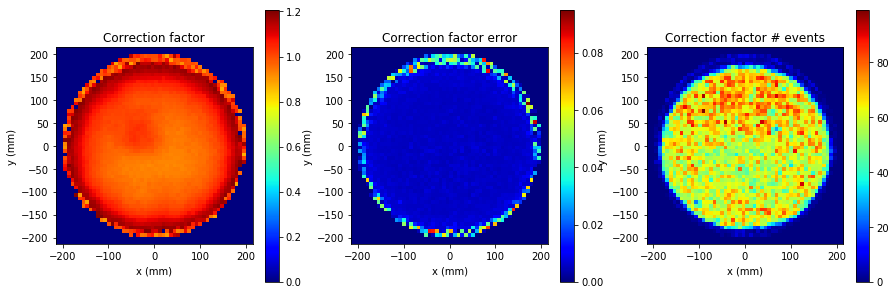

In [4]:
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b10.corr"
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/old/mcKr.corr"
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
fcorr = tb.open_file(corr_file,'r')

ncbins = 54

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor (MC)
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)
print(xbin)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))
    
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Perform initial analysis with a DST

In [5]:
# code from Gonzalo
run_number    = 4484
inputfilename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/dst/dst_{1}.root.h5".format(run_number,run_number)
full = dstf.load_dst(inputfilename, "DST", "Events")
print(len(full))
full.head()

9504


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.499970e+09,0,1,275.0,59.174740,353.042031,847550.0,55.457375,18207.923828,...,1029962.5,476,182.4125,182.4125,-58.229906,81.104390,99.843097,2.193476,45.702965,47.963936
1,3,1.499970e+09,0,1,325.0,76.771904,457.793548,732400.0,56.277750,18307.046875,...,1017012.5,452,284.6125,284.6125,15.476704,140.621437,141.470551,1.461178,50.471513,49.563160
2,5,1.499970e+09,0,1,300.0,85.588783,468.010359,865650.0,79.354250,18597.736328,...,1034887.5,597,169.2375,169.2375,-129.406866,-40.362241,135.555330,-2.839253,59.320594,49.241932
3,6,1.499970e+09,0,1,300.0,124.138268,708.545367,648700.0,73.337500,17789.914062,...,1030162.5,613,381.4625,381.4625,-77.007666,-104.085437,129.475707,-2.207770,50.810358,71.496101
4,7,1.499970e+09,0,2,275.0,77.786621,427.330454,988525.0,117.973250,17468.431641,...,1006412.5,363,17.8875,17.8875,114.734600,-118.843244,165.190027,-0.802986,42.140763,43.704905


Number of events used in histograms = 7779


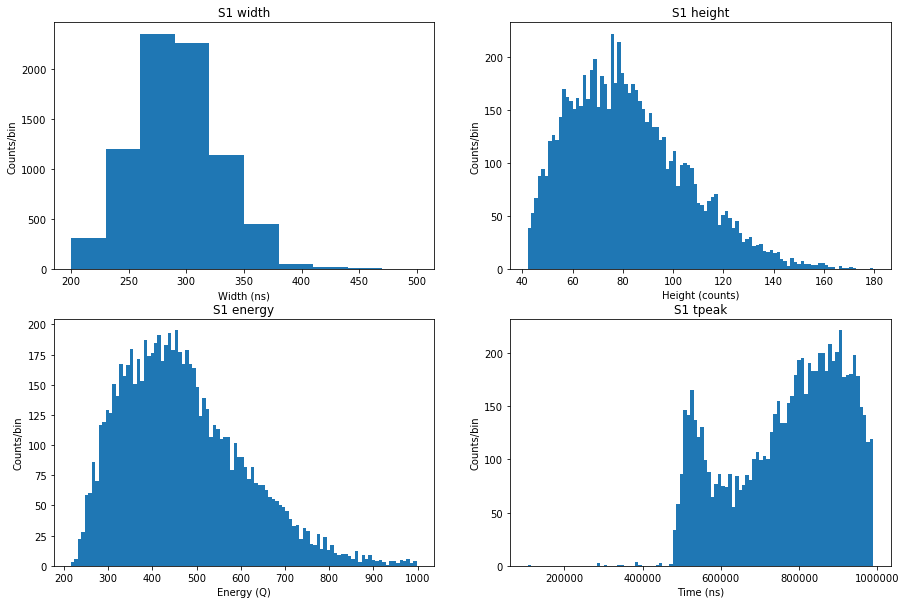

In [6]:
# histograms of quantities of interest (S1)
print("Number of events used in histograms = {0}".format(len(full[full.peak == 0])))
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(full.S1w[full.peak == 0],bins=10)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S1 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(full.S1h[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 height')
plt.xlabel('Height (counts)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(full.S1e[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 energy')
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(full.S1t[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

Number of events used in histograms = 9504


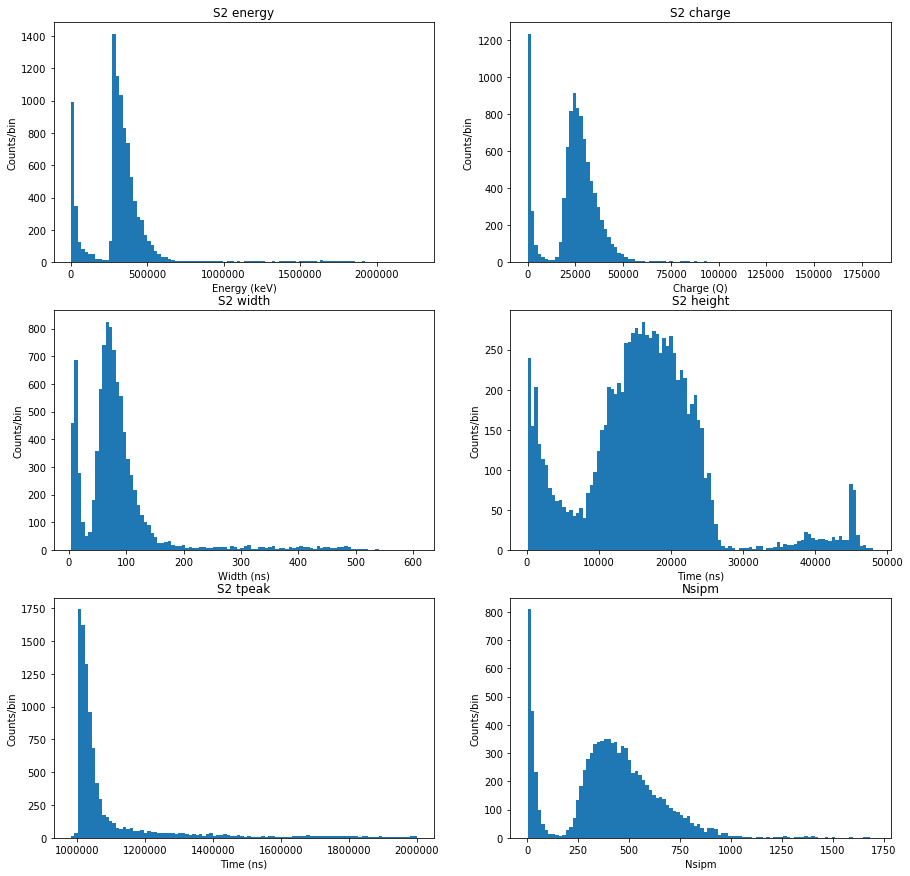

In [7]:
# histograms of quantities of interest (S2)
print("Number of events used in histograms = {0}".format(len(full)))
fig = plt.figure(1)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(321);
plt.hist(full.S2e,bins=100)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S2 energy')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(322)
plt.hist(full.S2q,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 charge')
plt.xlabel('Charge (Q)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(323)
plt.hist(full.S2w,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(324)
plt.hist(full.S2h,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 height')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax5 = fig.add_subplot(325)
plt.hist(full.S2t,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax6 = fig.add_subplot(326)
plt.hist(full.Nsipm,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('Nsipm')
plt.xlabel('Nsipm')
plt.ylabel('Counts/bin')

In [8]:
# show energy spectrum directly from DST


## Read the PMaps and construct the hit collection for a given event
This will be performed in the future by Penthesilea.

In [9]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q,l_X0,l_Y0):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(20.0)
    fig.set_figwidth(20.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    plt.scatter(l_X,l_Y,c=l_Q)
    plt.colorbar()
#    for xx,yy,qq in zip(l_X,l_Y,l_Q):
#        r = Ellipse(xy=(xx, yy), width=4., height=4.);
#        r.set_facecolor('0');
#        r.set_alpha(qq);
#        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    ax1.scatter(l_X0,l_Y0,marker='x',s=100,color='red')
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [197]:
# Configuration information
tot_Emin = 50000; tot_Emax = 1000000
tlife = 1200
cfile = '/Users/jrenner/IFIC/IC-1/invisible_cities/config/s12_selector_4491.conf'

# read the configuration file
conf = configure(['bar', cfile])
_s1s2_selector = S12Selector(**conf.as_dict)

In [11]:
hitc_evt = []; hitc_mc = []; ext1_mc = []; ext2_mc = []
evtnum_hitc = []
#nfiles = 107
print_cut = False
tbl_ri = 0
tot_evts_sum = 0
l_rnums = [4484, 4491] #[4484, 4489, 4491] # [1000]
l_nfiles = [122, 107] #[122, 95, 107] # [1]

for rnum,nfiles in zip(l_rnums,l_nfiles):
    
    print("\n--- RUN {0} ---".format(rnum))
    for ifile in range(nfiles):

        print("File {0} of {1}...".format(ifile,nfiles))

        if(ifile < 10): fstr = "00{0}".format(ifile)
        elif(ifile < 100): fstr = "0{0}".format(ifile)
        else: fstr = "{0}".format(ifile)

        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{0}_0_7bar_pmaps_10000.root.h5".format(ifile)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/{0}/pmaps/pair_1592keV_z250mm_10evt_pmaps.root.h5".format(rnum)
        filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/pmaps/pmaps.gdcsnext.{1}_{2}.root.h5".format(rnum,fstr,rnum)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3913/pmaps/pmaps.gdcsnext.{0}_3913.root.h5".format(fstr)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3755/pmaps/pmaps.gdcsnext.{0}_3755.root.h5".format(fstr)
        if(not os.path.isfile(filename)):
            print("File {0} does not exist. Skipping.".format(ifile))
            continue
        try:
            S1s, S2s, S2Sis = load_pmaps(filename)
        except (ValueError, tb.exceptions.NoSuchNodeError):
            print("Empty file {0}. Skipping.".format(ifile))
        event_numbers, timestamps = get_event_numbers_and_timestamps_from_file_name(filename)
        ftbl = tb.open_file(filename,'r')

        tot_evts_sum += len(event_numbers)
        print("... {0} events in file ({1} total)".format(len(event_numbers), tot_evts_sum))
        for evt_number, evt_time in zip(event_numbers,timestamps):
            #print("Processing event {0}".format(evt_number))
            hitc = []

            s1   = S1s  .get(evt_number, {})
            s2   = S2s  .get(evt_number, {})
            s2si = S2Sis.get(evt_number, {})

            if(not s1 or not s2 or not s2si):
                if(print_cut):
                    print("Skipping event {0}:".format(evt_number))
                    if(not s1): print("-- empty s1")
                    if(not s2): print("-- empty s2")
                    if(not s2si): print("-- empty s2si")
                continue
            if(len(s2.s2d) != len(s2si.s2sid)): 
                if(print_cut): print("Skipping event {0}: length of s2 does not match that of s2si".format(evt_number))
                continue
            #print(type(s2si))
            #print(s2.s2d.keys())
            #print(s2si.s2sid.keys())

            f1 = s1s2_filter(_s1s2_selector, s1, s2, s2si)
            f2 = s2si_filter(s2si)
            if not f1 or not f2:
                continue

            esum = sum([sum(earr) for pnum,(tarr,earr) in sorted(s2.s2d.items())])

            if(not (tot_Emin <= esum <= tot_Emax)):
                if(print_cut): print("Skipping event {0}: did not make energy cuts...".format(evt_number))
            else:
                t, e = next(iter(s1.s1d.values()))
                S1t  = t[np.argmax(e)]
                s2, s2si = pmp.rebin_s2si(s2,s2si,2)
                #S2, Si = rebin_s2(S2, Si)

                npeak = 0
                for peak_no, (t_peak, e_peak) in sorted(s2.s2d.items()):
                    si = s2si.s2sid[peak_no]
                    e_left = 0
                    for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
                        #print("Slice number {0}".format(slice_no))
                        incomplete = False
                        for sipm_no,sipm in si.items():
                            if(slice_no >= len(sipm)):
                                incomplete = True
                        if(incomplete):
                            print("WARNING: incomplete charge information for slice ")
                            e_left += e_slice
                        else:
                            clusters = compute_xy_position(si, slice_no)
                            #print("Computed pos")
                            if(len(clusters) == 0):
                                e_left += e_slice
                            else:
                                es       = split_energy(e_slice + e_left, clusters)
                                z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0
                                for c, e in zip(clusters, es):
                                    hit       = Hit(peak_no,c,z,e)
                                    #print("hit at ({0},{1},{2};{3})".format(hit.X,hit.Y,hit.Z,hit.E))
                                    #print("hit at ({0},{1},{2};{3})".format(hit.pos[0],hit.pos[1],hit.pos[2],hit.E))
                                    hitc.append(hit)
                                e_left = 0
                    if(len(hitc) > 0 and e_left > 0):
                        hitc[-1].energy += e_left
                    npeak += 1

                hitc_evt.append(hitc)
                evtnum_hitc.append(evt_number)

                # record MC information if available
                if(ftbl.__contains__('/MC')):
                    hitcm = []
                    mctbl = ftbl.root.MC.MCTracks
                    mcevt = 0; eemax = 0
                    ext1 = np.zeros(3); ext2 = np.zeros(3)
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['event_indx'] != evt_number):
                    #    tbl_ri += 1
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['mctrk_indx'] == evt_number):
                    while(tbl_ri < len(mctbl) and (tbl_ri == 0 or mctbl[tbl_ri]['mctrk_indx'] >= mctbl[tbl_ri-1]['mctrk_indx'])):
                        hpos = mctbl[tbl_ri]['hit_position']
                        henergy = mctbl[tbl_ri]['hit_energy']
                        hit = Hit(0,Cluster(0, xy(hpos[0],hpos[1]), xy(0,0), 0),hpos[2],henergy)
                        hitcm.append(hit)
                        if(mctbl[tbl_ri]['particle_name'] == 'e+'):
                            ext1[0] = hpos[0]; ext1[1] = hpos[1]; ext1[2] = hpos[2]
                        elif(mctbl[tbl_ri]['particle_name'] == 'e-' and mctbl[tbl_ri]['energy'] > eemax):
                            ext2[0] = hpos[0]; ext2[1] = hpos[1]; ext2[2] = hpos[2]
                        print("MCTrack index = {0}".format(mctbl[tbl_ri]['mctrk_indx']))
                        tbl_ri += 1
                    hitc_mc.append(hitcm)
                    ext1_mc.append(ext1)
                    ext2_mc.append(ext2)
                    mcevt += 1
                    tbl_ri += 1

        ftbl.close()
    print("Produced hit collections for {0} events ({1} events in MC truth).".format(len(hitc_evt),len(hitc_mc)))


--- RUN 4484 ---
File 0 of 122...
... 112 events in file (112 total)
File 1 of 122...
... 1 events in file (113 total)
File 2 of 122...
... 95 events in file (208 total)
File 3 of 122...
... 112 events in file (320 total)
File 4 of 122...
... 112 events in file (432 total)
File 5 of 122...
... 100 events in file (532 total)
File 6 of 122...
... 111 events in file (643 total)
File 7 of 122...
... 112 events in file (755 total)
File 8 of 122...
... 112 events in file (867 total)
File 9 of 122...
... 112 events in file (979 total)
File 10 of 122...
... 47 events in file (1026 total)
File 11 of 122...
... 112 events in file (1138 total)
File 12 of 122...
... 75 events in file (1213 total)
File 13 of 122...
... 112 events in file (1325 total)
File 14 of 122...
... 16 events in file (1341 total)
File 15 of 122...
... 112 events in file (1453 total)
File 16 of 122...
... 112 events in file (1565 total)
File 17 of 122...
... 111 events in file (1676 total)
File 18 of 122...
... 112 events in 

File 25 of 107...
... 112 events in file (12307 total)
File 26 of 107...
... 112 events in file (12419 total)
File 27 of 107...
... 87 events in file (12506 total)
File 28 of 107...
... 6 events in file (12512 total)
File 29 of 107...
... 112 events in file (12624 total)
File 30 of 107...
... 91 events in file (12715 total)
File 31 of 107...
... 51 events in file (12766 total)
File 32 of 107...
... 105 events in file (12871 total)
File 33 of 107...
... 112 events in file (12983 total)
File 34 of 107...
... 45 events in file (13028 total)
File 35 of 107...
... 65 events in file (13093 total)
File 36 of 107...
... 112 events in file (13205 total)
File 37 of 107...
... 112 events in file (13317 total)
File 38 of 107...
... 31 events in file (13348 total)
File 39 of 107...
... 112 events in file (13460 total)
File 40 of 107...
... 89 events in file (13549 total)
File 41 of 107...
... 12 events in file (13561 total)
File 42 of 107...
... 2 events in file (13563 total)
File 43 of 107...
... 

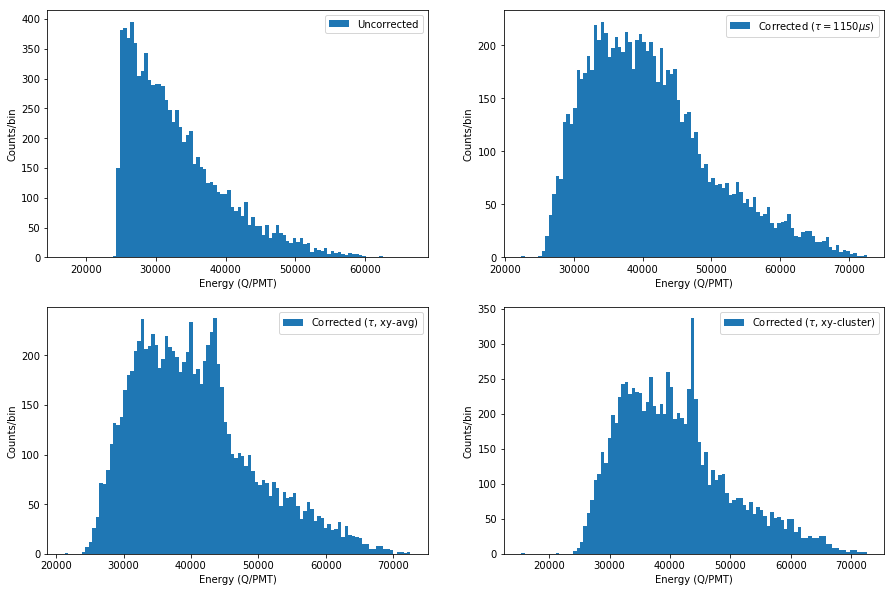

In [162]:
# energy spectrum
npmts = 11
ebins = 100
emin_hist = 150000; emax_hist = 800000
e_spec = []; emc_spec = []; r_spec = []; z_spec = []; evtNum_spec = []
ecorr_avg_spec = []; ecorr_tau_spec = []; ecorr_slice_spec = []
for ee in range(len(hitc_evt)):
    evt_E = sum([hh.E for hh in hitc_evt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[ee]])
    if(len(hitc_evt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(ee < len(hitc_mc)): evt_Emc = sum([hh.E for hh in hitc_mc[ee]])
    hr = np.array([np.sqrt(hh.X**2 + hh.Y**2) < 120. for hh in hitc_evt[ee]])
    #print("E = {0}, with tau = {1}, with xy = {2}, with slices = {3}".format(evt_E,evt_Ecorrtau,evt_Ecorrtau_xy,evt_Ecorrtau_xy_slice))
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 150.): #hr.all()):
        e_spec.append(evt_E)
        r_spec.append(evt_R)
        z_spec.append(evt_Z)
        ecorr_tau_spec.append(evt_Ecorrtau)
        ecorr_avg_spec.append(evt_Ecorrtau_xy)
        ecorr_slice_spec.append(evt_Ecorrtau_xy_slice)
        evtNum_spec.append(evtnum_hitc[ee])
    emc_spec.append(evt_Emc)

e_spec = np.array(e_spec)
ecorr_tau_spec = np.array(ecorr_tau_spec)
ecorr_avg_spec = np.array(ecorr_avg_spec)
ecorr_slice_spec = np.array(ecorr_slice_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(e_spec/npmts,bins=ebins,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(ecorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

In [228]:
# find the run cutoff point (if necessary)
print(evtnum_hitc[6117:7000])

[2, 3, 4, 7, 8, 12, 13, 16, 17, 20, 23, 24, 25, 28, 31, 35, 36, 37, 38, 39, 41, 44, 46, 47, 49, 50, 52, 53, 54, 56, 57, 59, 60, 62, 63, 65, 66, 69, 73, 74, 75, 76, 77, 79, 81, 82, 113, 117, 120, 122, 123, 124, 125, 126, 127, 129, 131, 133, 137, 139, 141, 142, 143, 145, 149, 150, 151, 158, 160, 225, 226, 227, 229, 235, 236, 238, 242, 243, 246, 248, 251, 252, 253, 254, 255, 256, 257, 337, 338, 339, 340, 345, 348, 353, 354, 355, 356, 360, 362, 363, 366, 367, 368, 373, 374, 377, 379, 380, 383, 385, 390, 392, 394, 395, 397, 398, 399, 400, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 420, 423, 425, 431, 436, 437, 438, 439, 442, 443, 444, 446, 449, 450, 452, 453, 455, 456, 459, 460, 461, 462, 463, 466, 468, 469, 470, 471, 472, 474, 477, 480, 482, 484, 486, 488, 490, 491, 492, 495, 496, 497, 501, 502, 503, 504, 505, 508, 509, 511, 512, 513, 515, 517, 518, 519, 520, 521, 522, 523, 525, 526, 531, 532, 534, 535, 536, 538, 539, 543, 544, 545, 546, 547, 549, 551, 552, 553, 554, 559, 560, 561, 

In [229]:
# create the corrected hit collection
hitc_cevt = []
#for ee in range(len(hitc_evt)):
for ee in range(6117):
    hc_corr = []
    for hh in hitc_evt[ee]:
        hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
        hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
        hc_corr.append(hcorr)
    hitc_cevt.append(hc_corr)

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


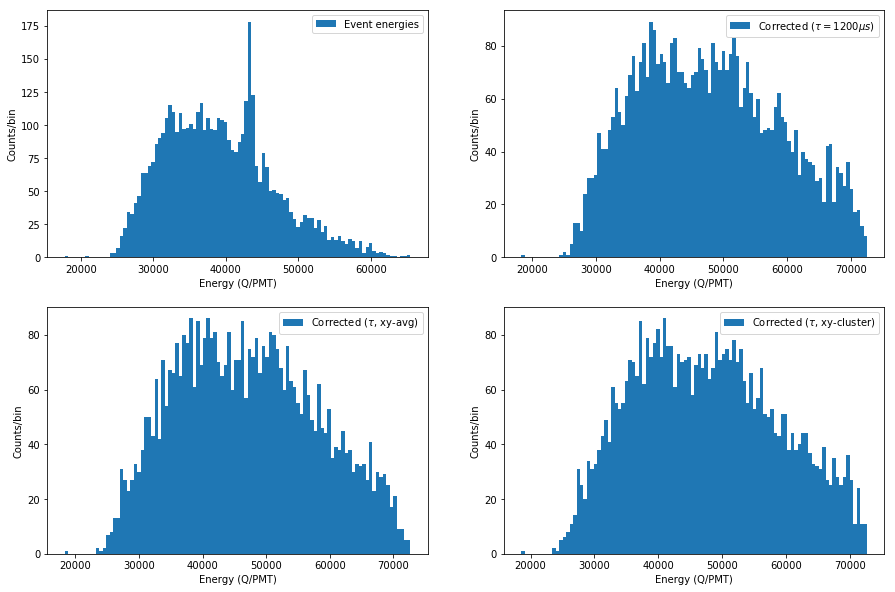

In [230]:
# energy spectrum
ec_spec = []; rc_spec = []; zc_spec = []; evtNumc_spec = []
eccorr_avg_spec = []; eccorr_tau_spec = []; eccorr_slice_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(len(hitc_cevt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_cevt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 150.): #hr.all()):
        ec_spec.append(evt_E)
        rc_spec.append(evt_R)
        zc_spec.append(evt_Z)
        eccorr_tau_spec.append(evt_Ecorrtau)
        eccorr_avg_spec.append(evt_Ecorrtau_xy)
        eccorr_slice_spec.append(evt_Ecorrtau_xy_slice)
        evtNumc_spec.append(evtnum_hitc[ee])

rc_spec = np.array(rc_spec)
zc_spec = np.array(zc_spec)
ec_spec = np.array(ec_spec)
eccorr_tau_spec = np.array(eccorr_tau_spec)
eccorr_avg_spec = np.array(eccorr_avg_spec)
eccorr_slice_spec = np.array(eccorr_slice_spec)
evtNumc_spec = np.array(evtNumc_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(ec_spec/npmts,bins=ebins,label='Event energies')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(eccorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(eccorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(eccorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

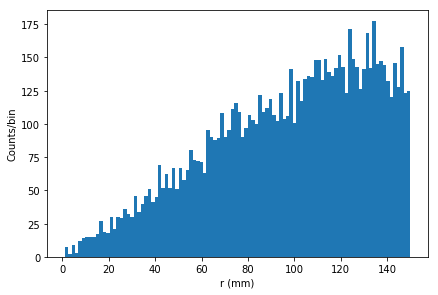

In [231]:
# look at the distribution in r
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

# event distribution vs. R
ax1 = fig.add_subplot(221);
plt.hist(r_spec,bins=100)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

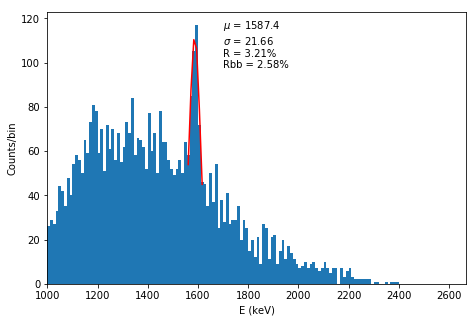

In [234]:
# closer look at the energy spectrum
CAL_FACTOR = 1620/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(ec_spec*CAL_FACTOR, 150, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 467e3*CAL_FACTOR, 488e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

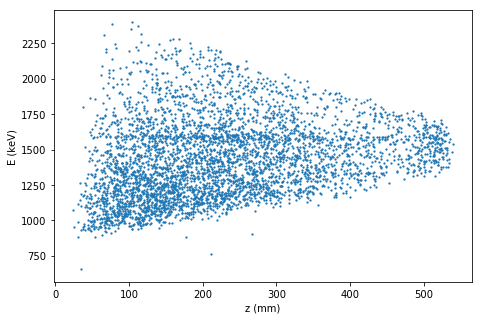

In [235]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.scatter(zc_spec[0:4405],ec_spec[0:4405]*CAL_FACTOR,s=1.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
#plt.ylim([100000,900000])
#plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

# Paolina analysis

In [240]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm
ECCUT_LOW = 250000
ECCUT_HIGH = 1000000
DIST_CUT = 100.
EBLOB_CUT = 300000    # do not accept events with a single blob > this energy

In [241]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []; l_eevt = []; l_etrk = []
for nevt in range(len(hitc_cevt)):
    
    hitc = hitc_cevt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[nevt]])
    evt_E = sum([hh.E for hh in hitc_cevt[nevt]])
    if(len(hitc_cevt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Make energy and radial cuts.
    if(not (evt_E > ECCUT_LOW and evt_E < ECCUT_HIGH) or evt_R >= 150.):
        continue

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    #itmax = np.argmax([len(t) for t in trks])
    itmax = np.argmax([sum([vox.E for vox in t.nodes()]) for t in trks])
    etmax = sum([vox.E for vox in trks[itmax].nodes()])
    
    # voxel fraction cut
    #if(len(trks[itmax])/len(voxels) < 0.95):
    #    continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add to the distributions if the blob energy does not exceed the upper limit
    if(Eblob1 < EBLOB_CUT and Eblob2 < EBLOB_CUT):
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_eevt.append(evt_E)
        l_etrk.append(etmax)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_eevt = np.array(l_eevt)
l_etrk = np.array(l_etrk)

Track 0 with 40 hits...
Track 3 with 50 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 21 voxels, distance = 135.57190617765733
Track 5 with 29 hits...
Track 6 with 40 hits...
Track 8 with 53 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 24 voxels, distance = 206.6665208345363
Track 9 with 55 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 211.17287049678046
Track 10 with 50 hits...
Found 4 tracks of 10979; max containing 11 voxels; total of 23 voxels, distance = 108.4358323027922
Track 11 with 50 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 221.9696910486081
Track 12 with 44 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 19 voxels, distance = 101.31129697092186
Track 13 with 40 hits...
Track 14 with 48 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 191.50553383377687
Track 16 with 23 hits...
Tr

Track 139 with 51 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 27 voxels, distance = 129.41833540592768
Track 140 with 54 hits...
Track 142 with 39 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 173.9720317393563
Track 143 with 18 hits...
Track 147 with 38 hits...
Track 148 with 45 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 113.05327416867262
Track 149 with 64 hits...
Found 3 tracks of 10979; max containing 25 voxels; total of 28 voxels, distance = 133.40914822133027
Track 150 with 29 hits...
Track 151 with 19 hits...
Track 152 with 55 hits...
Found 4 tracks of 10979; max containing 19 voxels; total of 26 voxels, distance = 101.91476329879967
Track 153 with 36 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 150.78171129933088
Track 154 with 58 hits...
Found 3 tracks of 10979; max containing 23 voxels; total of 28 voxels, distance = 1

Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 136.51462857050035
Track 296 with 59 hits...
Found 2 tracks of 10979; max containing 34 voxels; total of 35 voxels, distance = 260.4222535438729
Track 297 with 34 hits...
Track 298 with 37 hits...
Track 299 with 32 hits...
Track 300 with 41 hits...
Track 302 with 27 hits...
Track 303 with 44 hits...
Track 304 with 25 hits...
Track 305 with 39 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 150.5271682908684
Track 307 with 38 hits...
Track 308 with 38 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 20 voxels, distance = 138.30915168901646
Track 310 with 41 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 23 voxels, distance = 100.93526014271539
Track 311 with 49 hits...
Found 2 tracks of 10979; max containing 25 voxels; total of 26 voxels, distance = 159.461838642218
Track 312 with 34 hits...
Track 314 with 46 hits...
Found 2 

Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 252.34233240182238
Track 457 with 48 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 195.4274408830787
Track 459 with 33 hits...
Track 460 with 27 hits...
Track 461 with 30 hits...
Track 462 with 35 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 107.78641620919481
Track 463 with 31 hits...
Track 464 with 33 hits...
Track 466 with 32 hits...
Track 467 with 36 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 119.10587373820911
Track 468 with 32 hits...
Track 469 with 32 hits...
Track 470 with 44 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 141.51715641381728
Track 471 with 44 hits...
Track 472 with 41 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 20 voxels, distance = 111.43688552313196
Track 473 with 34 hits...
Track

Found 4 tracks of 10979; max containing 23 voxels; total of 29 voxels, distance = 148.80313670082757
Track 586 with 40 hits...
Track 587 with 49 hits...
Found 3 tracks of 10979; max containing 20 voxels; total of 27 voxels, distance = 112.3087589956776
Track 588 with 61 hits...
Found 2 tracks of 10979; max containing 29 voxels; total of 31 voxels, distance = 150.59986366671998
Track 589 with 32 hits...
Track 590 with 54 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 187.2425962763108
Track 591 with 34 hits...
Track 592 with 30 hits...
Track 594 with 27 hits...
Track 595 with 36 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 109.97428275515703
Track 596 with 34 hits...
Track 597 with 36 hits...
Track 598 with 52 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 24 voxels, distance = 105.80996615615224
Track 599 with 50 hits...
Found 3 tracks of 10979; max containing 16 voxels; total o

Track 751 with 74 hits...
Found 1 tracks of 10979; max containing 36 voxels; total of 36 voxels, distance = 371.5200409077751
Track 752 with 31 hits...
Track 753 with 31 hits...
Track 754 with 35 hits...
Track 755 with 29 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 113.68725898835848
Track 756 with 39 hits...
Track 757 with 33 hits...
Track 758 with 33 hits...
Track 760 with 24 hits...
Track 761 with 62 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 31 voxels, distance = 108.06130028727031
Track 762 with 48 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 131.92010919550296
Track 763 with 30 hits...
Track 764 with 29 hits...
Track 765 with 41 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 24 voxels, distance = 286.49503007678766
Track 767 with 27 hits...
Track 768 with 35 hits...
Track 769 with 33 hits...
Track 770 with 34 hits...
Track 771 with 29 hits...
Tr

Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 119.70646270181756
Track 906 with 35 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 100.28279257456653
Track 907 with 39 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 211.77659239016745
Track 908 with 29 hits...
Track 909 with 37 hits...
Track 911 with 30 hits...
Track 912 with 36 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 139.70404428501573
Track 913 with 37 hits...
Track 914 with 49 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 103.34701871916621
Track 915 with 57 hits...
Found 3 tracks of 10979; max containing 23 voxels; total of 31 voxels, distance = 118.90586723383132
Track 916 with 39 hits...
Track 917 with 28 hits...
Track 919 with 43 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 

Track 1051 with 54 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 178.77330086105627
Track 1052 with 35 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 104.10462456387316
Track 1053 with 31 hits...
Track 1055 with 36 hits...
Track 1056 with 37 hits...
Track 1057 with 46 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 22 voxels, distance = 140.9651653482245
Track 1058 with 46 hits...
Track 1059 with 24 hits...
Track 1060 with 34 hits...
Track 1061 with 42 hits...
Found 4 tracks of 10979; max containing 14 voxels; total of 19 voxels, distance = 137.01078991259823
Track 1062 with 64 hits...
Found 4 tracks of 10979; max containing 21 voxels; total of 30 voxels, distance = 153.57918071232143
Track 1063 with 30 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 13 voxels, distance = 103.91127696037518
Track 1064 with 70 hits...
Found 1 tracks of 10979; max containing 37 v

Track 1197 with 30 hits...
Track 1198 with 38 hits...
Track 1199 with 36 hits...
Track 1200 with 43 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 129.71438654162156
Track 1201 with 35 hits...
Track 1202 with 43 hits...
Track 1203 with 54 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 129.8300101271135
Track 1204 with 32 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 107.7984342689328
Track 1205 with 40 hits...
Track 1206 with 43 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 20 voxels, distance = 134.99733649099426
Track 1207 with 30 hits...
Track 1208 with 41 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 167.10035352178068
Track 1209 with 76 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 32 voxels, distance = 110.65677230737941
Track 1210 with 34 hits...
Track 1211 with 29

Track 1356 with 34 hits...
Track 1357 with 42 hits...
Track 1358 with 38 hits...
Track 1359 with 57 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 205.84844827080974
Track 1360 with 38 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 19 voxels, distance = 135.46865515553202
Track 1361 with 45 hits...
Track 1362 with 20 hits...
Track 1365 with 21 hits...
Track 1368 with 42 hits...
Track 1369 with 27 hits...
Track 1370 with 53 hits...
Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 184.53419315447928
Track 1371 with 50 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 27 voxels, distance = 146.26682321860125
Track 1372 with 34 hits...
Track 1373 with 44 hits...
Track 1374 with 32 hits...
Track 1375 with 30 hits...
Track 1376 with 55 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 23 voxels, distance = 104.3824697145398
Track 1377 with 37 hits...
Track 1378

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 114.73480045623042
Track 1434 with 37 hits...
Track 1435 with 32 hits...
Track 1437 with 51 hits...
Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 122.35293221969826
Track 1438 with 40 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 128.79523240056486
Track 1439 with 43 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 118.06840030530189
Track 1441 with 34 hits...
Track 1442 with 24 hits...
Found 2 tracks of 10979; max containing 11 voxels; total of 12 voxels, distance = 107.06573654288364
Track 1443 with 31 hits...
Track 1444 with 35 hits...
Track 1445 with 38 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 120.78796253088265
Track 1446 with 33 hits...
Track 1447 with 28 hits...
Track 1448 with 55 hits...
Found 3 tracks of 10979; max containing 20 

Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 127.06788291815377
Track 1563 with 29 hits...
Track 1564 with 45 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 111.36230515443341
Track 1565 with 30 hits...
Track 1566 with 27 hits...
Track 1567 with 32 hits...
Track 1569 with 39 hits...
Track 1571 with 43 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 125.26593438464535
Track 1572 with 24 hits...
Track 1573 with 44 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 110.81392722214828
Track 1574 with 35 hits...
Track 1575 with 38 hits...
Track 1576 with 25 hits...
Track 1577 with 40 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 146.58143782492937
Track 1578 with 36 hits...
Track 1579 with 36 hits...
Track 1580 with 23 hits...
Track 1581 with 38 hits...
Found 1 tracks of 10979; max contain

Track 1703 with 32 hits...
Track 1704 with 34 hits...
Track 1706 with 49 hits...
Found 4 tracks of 10979; max containing 17 voxels; total of 27 voxels, distance = 161.4380764275012
Track 1707 with 57 hits...
Track 1708 with 32 hits...
Track 1709 with 43 hits...
Track 1710 with 36 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 23 voxels, distance = 105.8918041916811
Track 1712 with 34 hits...
Track 1713 with 33 hits...
Track 1714 with 38 hits...
Track 1715 with 53 hits...
Found 2 tracks of 10979; max containing 25 voxels; total of 26 voxels, distance = 189.26339333330398
Track 1716 with 46 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 151.00711151006305
Track 1717 with 29 hits...
Track 1718 with 66 hits...
Found 1 tracks of 10979; max containing 37 voxels; total of 37 voxels, distance = 313.4399253109421
Track 1719 with 28 hits...
Track 1720 with 32 hits...
Track 1721 with 39 hits...
Track 1722 with 45 hits...
Found 1 trac

Found 2 tracks of 10979; max containing 32 voxels; total of 34 voxels, distance = 256.25386980132043
Track 1852 with 32 hits...
Found 3 tracks of 10979; max containing 11 voxels; total of 14 voxels, distance = 104.80371997550989
Track 1853 with 43 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 24 voxels, distance = 136.55439439870645
Track 1854 with 31 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 106.57237811705122
Track 1855 with 33 hits...
Track 1856 with 44 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 123.25874333565679
Track 1857 with 64 hits...
Found 3 tracks of 10979; max containing 28 voxels; total of 35 voxels, distance = 222.8862248501612
Track 1858 with 48 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 172.34635859699594
Track 1860 with 53 hits...
Track 1861 with 40 hits...
Track 1862 with 32 hits...
Track 1863 with 30 hits.

Track 2001 with 32 hits...
Track 2002 with 56 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 29 voxels, distance = 236.74957889402035
Track 2003 with 36 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 100.12102392374419
Track 2005 with 32 hits...
Track 2006 with 40 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 24 voxels, distance = 143.69538323227985
Track 2007 with 35 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 20 voxels, distance = 120.36097570079744
Track 2008 with 27 hits...
Track 2009 with 53 hits...
Found 2 tracks of 10979; max containing 28 voxels; total of 29 voxels, distance = 146.72394809285439
Track 2010 with 44 hits...
Track 2011 with 32 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 143.19795335194385
Track 2012 with 48 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 25 voxels, distance = 109.16316300957

Track 2152 with 35 hits...
Track 2153 with 35 hits...
Track 2154 with 41 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 183.43512601192688
Track 2155 with 30 hits...
Track 2156 with 43 hits...
Track 2157 with 42 hits...
Track 2158 with 29 hits...
Track 2159 with 43 hits...
Track 2160 with 34 hits...
Track 2161 with 42 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 130.36096590224784
Track 2162 with 27 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 141.20988605653898
Track 2163 with 46 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 116.15448846099133
Track 2164 with 30 hits...
Track 2165 with 42 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 131.48619528882912
Track 2166 with 32 hits...
Track 2168 with 31 hits...
Track 2169 with 43 hits...
Track 2170 with 32 hits...
Found 1 t

Track 2290 with 37 hits...
Track 2292 with 44 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 151.6449755348109
Track 2293 with 27 hits...
Track 2294 with 36 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 126.18383899382137
Track 2295 with 44 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 112.3608933798287
Track 2296 with 49 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 151.89825026267116
Track 2297 with 58 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 22 voxels, distance = 162.26093831536326
Track 2298 with 42 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 135.5282667324882
Track 2299 with 59 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 35 voxels, distance = 143.8260475501646
Track 2301 with 33 hits...
Found 1 tracks of 10979; ma

Track 2408 with 50 hits...
Track 2409 with 32 hits...
Track 2411 with 44 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 22 voxels, distance = 115.56040548969978
Track 2412 with 37 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 115.33774498051423
Track 2413 with 63 hits...
Found 1 tracks of 10979; max containing 33 voxels; total of 33 voxels, distance = 157.12029594072715
Track 2414 with 22 hits...
Track 2415 with 61 hits...
Track 2416 with 34 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 120.37726925798447
Track 2417 with 46 hits...
Track 2419 with 48 hits...
Track 2420 with 34 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 119.65123157177719
Track 2421 with 43 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 19 voxels, distance = 108.19278417951392
Track 2422 with 27 hits...
Track 2423 with 43 hits...
Found 1 tracks o

Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 130.74827542670187
Track 2540 with 55 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 23 voxels, distance = 124.46697187274567
Track 2541 with 45 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 20 voxels, distance = 104.73647982519
Track 2542 with 70 hits...
Track 2544 with 36 hits...
Track 2545 with 41 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 25 voxels, distance = 186.32580102218046
Track 2548 with 49 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 105.35158102447663
Track 2549 with 39 hits...
Track 2550 with 86 hits...
Found 2 tracks of 10979; max containing 43 voxels; total of 44 voxels, distance = 357.5387002392444
Track 2554 with 37 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 149.9334296123267
Track 2555 with 31 hits...
Track 2557 with 42 hits...
T

Found 2 tracks of 10979; max containing 30 voxels; total of 31 voxels, distance = 149.59387437282234
Track 2678 with 49 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 22 voxels, distance = 173.14507737415116
Track 2680 with 41 hits...
Found 4 tracks of 10979; max containing 14 voxels; total of 20 voxels, distance = 105.39028137197917
Track 2681 with 34 hits...
Track 2682 with 30 hits...
Track 2683 with 24 hits...
Track 2685 with 38 hits...
Track 2686 with 33 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 101.16080099774629
Track 2687 with 31 hits...
Track 2689 with 44 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 18 voxels, distance = 133.22961464842476
Track 2690 with 32 hits...
Track 2691 with 50 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 130.64206875531414
Track 2692 with 34 hits...
Track 2693 with 21 hits...
Track 2694 with 31 hits...
Track 2695 with 

Track 2828 with 30 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 22 voxels, distance = 100.43778665418708
Track 2829 with 36 hits...
Track 2830 with 28 hits...
Track 2831 with 44 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 159.81031908332102
Track 2832 with 40 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 22 voxels, distance = 121.32813126046364
Track 2833 with 29 hits...
Track 2834 with 46 hits...
Track 2835 with 31 hits...
Track 2837 with 35 hits...
Track 2839 with 40 hits...
Track 2840 with 33 hits...
Track 2841 with 31 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 113.22090372400164
Track 2842 with 38 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 24 voxels, distance = 144.42268319476375
Track 2843 with 44 hits...
Found 4 tracks of 10979; max containing 16 voxels; total of 20 voxels, distance = 127.89802465694741
Track 2844 with 

Track 2977 with 49 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 127.0841426499494
Track 2978 with 41 hits...
Track 2979 with 40 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 136.33348029533417
Track 2980 with 41 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 155.64367990272717
Track 2981 with 37 hits...
Track 2982 with 59 hits...
Found 1 tracks of 10979; max containing 30 voxels; total of 30 voxels, distance = 229.7035163784936
Track 2983 with 31 hits...
Track 2985 with 42 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 123.84237407274145
Track 2989 with 27 hits...
Track 2990 with 77 hits...
Found 2 tracks of 10979; max containing 29 voxels; total of 30 voxels, distance = 177.51790571189125
Track 2991 with 46 hits...
Track 2992 with 60 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 29 voxels, d

Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 104.79506888179321
Track 3109 with 34 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 121.62262767941195
Track 3110 with 46 hits...
Found 3 tracks of 10979; max containing 11 voxels; total of 18 voxels, distance = 100.45179680665792
Track 3111 with 27 hits...
Found 1 tracks of 10979; max containing 11 voxels; total of 11 voxels, distance = 106.0644065853634
Track 3112 with 36 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 173.03536692319912
Track 3113 with 27 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 120.39796848592741
Track 3114 with 53 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 27 voxels, distance = 177.24455007793844
Track 3115 with 31 hits...
Track 3116 with 39 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distanc

Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 193.17393849183657
Track 3249 with 37 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 22 voxels, distance = 124.20212943724881
Track 3250 with 33 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 124.51528568898883
Track 3251 with 53 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 122.01366919646503
Track 3253 with 51 hits...
Found 3 tracks of 10979; max containing 24 voxels; total of 28 voxels, distance = 106.71939378291266
Track 3254 with 31 hits...
Found 1 tracks of 10979; max containing 13 voxels; total of 13 voxels, distance = 100.21066193359268
Track 3255 with 53 hits...
Track 3256 with 31 hits...
Track 3258 with 46 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 112.06656999066459
Track 3259 with 40 hits...
Track 3261 with 44 hits...
Found 2 tracks of 10979

Found 2 tracks of 10979; max containing 21 voxels; total of 26 voxels, distance = 156.19331787173797
Track 3392 with 34 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 156.2264954690873
Track 3393 with 26 hits...
Track 3394 with 43 hits...
Track 3395 with 31 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 142.10843173750945
Track 3397 with 34 hits...
Track 3398 with 47 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 187.08607423419573
Track 3399 with 34 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 133.19365238728565
Track 3400 with 44 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 107.95034473415791
Track 3401 with 41 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 161.15356463785665
Track 3402 with 54 hits...
Found 3 tracks of 10979;

Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 149.90209776900213
Track 3535 with 44 hits...
Found 4 tracks of 10979; max containing 14 voxels; total of 20 voxels, distance = 113.2029771933073
Track 3536 with 53 hits...
Found 4 tracks of 10979; max containing 16 voxels; total of 25 voxels, distance = 143.9663878982576
Track 3537 with 34 hits...
Track 3538 with 41 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 112.53628633852084
Track 3539 with 35 hits...
Track 3540 with 33 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 17 voxels, distance = 150.46624501376192
Track 3542 with 32 hits...
Found 3 tracks of 10979; max containing 11 voxels; total of 18 voxels, distance = 127.3664571674553
Track 3543 with 36 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 128.2411123764976
Track 3544 with 42 hits...
Track 3545 with 38 hits...
Track 3546 with 41 hits...


Track 3685 with 42 hits...
Track 3686 with 47 hits...
Track 3687 with 30 hits...
Track 3688 with 64 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 220.14394747656317
Track 3689 with 65 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 25 voxels, distance = 235.120403804741
Track 3690 with 39 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 125.03410481872179
Track 3691 with 45 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 130.41537153453572
Track 3692 with 43 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 109.10648532180116
Track 3693 with 44 hits...
Track 3694 with 38 hits...
Track 3695 with 38 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 157.07896456970056
Track 3696 with 50 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, d

Track 3815 with 34 hits...
Track 3817 with 52 hits...
Found 1 tracks of 10979; max containing 29 voxels; total of 29 voxels, distance = 123.1495955088961
Track 3819 with 60 hits...
Found 2 tracks of 10979; max containing 32 voxels; total of 33 voxels, distance = 103.84619035599502
Track 3820 with 34 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 126.43027765416473
Track 3821 with 57 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 149.22813404579685
Track 3822 with 54 hits...
Found 2 tracks of 10979; max containing 30 voxels; total of 31 voxels, distance = 235.95362885330144
Track 3823 with 39 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 157.56275492772386
Track 3825 with 29 hits...
Track 3826 with 40 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 20 voxels, distance = 139.03921865445872
Track 3827 with 49 hits...
Found 1 tracks of 10979;

Track 3941 with 39 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 117.30198867145235
Track 3943 with 39 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 21 voxels, distance = 135.03283740876202
Track 3944 with 42 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 144.39946495385522
Track 3945 with 26 hits...
Track 3946 with 35 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 157.09130788225747
Track 3947 with 41 hits...
Track 3948 with 32 hits...
Track 3949 with 29 hits...
Track 3950 with 37 hits...
Track 3951 with 42 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 101.94101082308718
Track 3952 with 35 hits...
Track 3953 with 28 hits...
Track 3954 with 49 hits...
Track 3955 with 26 hits...
Track 3956 with 32 hits...
Track 3957 with 33 hits...
Track 3958 with 36 hits...
Track 3959 with 51 hits...
Found 2 t

Found 1 tracks of 10979; max containing 32 voxels; total of 32 voxels, distance = 216.1550520758911
Track 4074 with 35 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 117.6755233476045
Track 4075 with 39 hits...
Track 4076 with 19 hits...
Track 4077 with 35 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 126.38107363618947
Track 4078 with 40 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 102.37890469897654
Track 4079 with 74 hits...
Found 3 tracks of 10979; max containing 27 voxels; total of 33 voxels, distance = 244.24448542899376
Track 4080 with 39 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 122.66530092120767
Track 4082 with 23 hits...
Track 4083 with 37 hits...
Track 4084 with 37 hits...
Found 3 tracks of 10979; max containing 14 voxels; total of 16 voxels, distance = 139.36035939990396
Track 4085 with 24 hits..

Found 2 tracks of 10979; max containing 20 voxels; total of 32 voxels, distance = 136.58935996561686
Track 4217 with 49 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 24 voxels, distance = 268.8817369168718
Track 4218 with 33 hits...
Track 4219 with 38 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 101.71391510702867
Track 4220 with 28 hits...
Track 4221 with 43 hits...
Track 4222 with 45 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 181.21526104903518
Track 4223 with 28 hits...
Track 4224 with 25 hits...
Track 4225 with 29 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 132.88918121199018
Track 4228 with 26 hits...
Track 4229 with 33 hits...
Track 4230 with 64 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 35 voxels, distance = 169.4550108996687
Track 4231 with 40 hits...
Found 1 tracks of 10979; max containing 15 vo

Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 115.14167651615998
Track 4361 with 39 hits...
Track 4362 with 57 hits...
Found 4 tracks of 10979; max containing 18 voxels; total of 28 voxels, distance = 182.41550680439275
Track 4363 with 50 hits...
Track 4364 with 43 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 169.57910565023732
Track 4366 with 45 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 23 voxels, distance = 138.55171334514927
Track 4367 with 63 hits...
Found 2 tracks of 10979; max containing 31 voxels; total of 32 voxels, distance = 272.95988922851404
Track 4368 with 29 hits...
Found 1 tracks of 10979; max containing 11 voxels; total of 11 voxels, distance = 108.63800376260633
Track 4369 with 38 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 20 voxels, distance = 116.35757152967417
Track 4370 with 34 hits...
Track 4371 with 55 hits...
Found 1 tracks of 10979

Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 140.46309432796627
Track 4491 with 47 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 170.49326303285824
Track 4493 with 44 hits...
Track 4494 with 46 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 26 voxels, distance = 134.21035995554604
Track 4497 with 38 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 109.30217706338436
Track 4498 with 35 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 150.75044834232872
Track 4499 with 44 hits...
Track 4500 with 36 hits...
Track 4501 with 38 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 139.29913000715615
Track 4503 with 37 hits...
Track 4504 with 45 hits...
Track 4506 with 37 hits...
Track 4507 with 26 hits...
Track 4508 with 65 hits...
Found 3 tracks of 10979; max containing 22 

Track 4638 with 44 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 21 voxels, distance = 146.10291524422303
Track 4639 with 43 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 25 voxels, distance = 115.01098941447434
Track 4640 with 19 hits...
Track 4642 with 33 hits...
Track 4643 with 28 hits...
Track 4645 with 23 hits...
Track 4646 with 42 hits...
Track 4647 with 50 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 196.10070397176779
Track 4648 with 38 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 221.39598280315212
Track 4649 with 38 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 122.55205855729555
Track 4654 with 33 hits...
Track 4655 with 30 hits...
Track 4656 with 62 hits...
Found 3 tracks of 10979; max containing 29 voxels; total of 36 voxels, distance = 185.97658075537962
Track 4657 with 34 hits...
Track 4659 with 

Found 2 tracks of 10979; max containing 22 voxels; total of 24 voxels, distance = 172.37445854883566
Track 4792 with 54 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 183.1013247187769
Track 4793 with 39 hits...
Track 4794 with 53 hits...
Track 4795 with 37 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 102.42985365903147
Track 4797 with 43 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 203.57695448196577
Track 4798 with 39 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 141.04488943956645
Track 4799 with 51 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 145.07215160126927
Track 4800 with 37 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 15 voxels, distance = 102.40491059428862
Track 4802 with 28 hits...
Track 4803 with 34 hits...
Found 1 tracks of 10979;

Track 4950 with 50 hits...
Track 4951 with 30 hits...
Track 4952 with 38 hits...
Track 4954 with 30 hits...
Track 4956 with 30 hits...
Found 3 tracks of 10979; max containing 12 voxels; total of 14 voxels, distance = 157.4417213269552
Track 4957 with 44 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 155.11751554470453
Track 4958 with 21 hits...
Track 4959 with 68 hits...
Found 2 tracks of 10979; max containing 32 voxels; total of 33 voxels, distance = 152.8703275241914
Track 4960 with 36 hits...
Track 4964 with 74 hits...
Found 3 tracks of 10979; max containing 34 voxels; total of 38 voxels, distance = 237.7040815832714
Track 4965 with 55 hits...
Found 3 tracks of 10979; max containing 30 voxels; total of 32 voxels, distance = 129.5510772732883
Track 4966 with 63 hits...
Track 4967 with 42 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 118.52431966431689
Track 4968 with 59 hits...
Found 1 tracks of 10

Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 108.9046636731029
Track 5096 with 36 hits...
Track 5098 with 25 hits...
Track 5099 with 44 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 131.85634222427467
Track 5100 with 27 hits...
Track 5101 with 49 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 21 voxels, distance = 143.59461175853767
Track 5103 with 31 hits...
Track 5104 with 57 hits...
Found 7 tracks of 10979; max containing 9 voxels; total of 26 voxels, distance = 107.22598628590885
Track 5105 with 46 hits...
Track 5106 with 49 hits...
Track 5107 with 36 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 15 voxels, distance = 110.36005996580435
Track 5109 with 30 hits...
Track 5110 with 36 hits...
Track 5111 with 29 hits...
Track 5112 with 30 hits...
Track 5114 with 35 hits...
Track 5115 with 43 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 vo

Track 5246 with 66 hits...
Found 4 tracks of 10979; max containing 12 voxels; total of 28 voxels, distance = 120.80614622019257
Track 5247 with 35 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 136.95354860309595
Track 5248 with 35 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 119.64284329832569
Track 5249 with 38 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 190.2338518885956
Track 5250 with 52 hits...
Track 5252 with 49 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 27 voxels, distance = 114.28938736877765
Track 5253 with 38 hits...
Found 4 tracks of 10979; max containing 20 voxels; total of 27 voxels, distance = 106.02587318604958
Track 5256 with 32 hits...
Track 5257 with 31 hits...
Track 5258 with 39 hits...
Track 5259 with 36 hits...
Track 5260 with 55 hits...
Track 5261 with 42 hits...
Found 3 tracks of 10979; max containing 13 v

Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 125.55613164446143
Track 5408 with 38 hits...
Track 5409 with 41 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 22 voxels, distance = 135.77643139954088
Track 5410 with 51 hits...
Found 6 tracks of 10979; max containing 18 voxels; total of 33 voxels, distance = 120.36412788724621
Track 5411 with 32 hits...
Track 5412 with 22 hits...
Found 2 tracks of 10979; max containing 10 voxels; total of 11 voxels, distance = 121.35716426077451
Track 5415 with 51 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 169.94394804086897
Track 5417 with 44 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 121.14434920810206
Track 5418 with 38 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 113.86743501554524
Track 5419 with 25 hits...
Found 1 tracks of 10979; max containing 13 voxels;

Track 5547 with 30 hits...
Track 5548 with 31 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 148.74426968581125
Track 5549 with 29 hits...
Track 5550 with 30 hits...
Track 5551 with 41 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 174.36971638250992
Track 5552 with 45 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 116.66784388516808
Track 5555 with 40 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 116.70488646261464
Track 5557 with 39 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 100.44754116490738
Track 5559 with 66 hits...
Track 5561 with 30 hits...
Track 5562 with 26 hits...
Track 5564 with 46 hits...
Track 5565 with 36 hits...
Track 5566 with 37 hits...
Track 5567 with 48 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 112.6672

Found 2 tracks of 10979; max containing 23 voxels; total of 26 voxels, distance = 204.48047146251434
Track 5684 with 48 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 103.08730977516565
Track 5685 with 42 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 108.43337681648283
Track 5686 with 38 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 120.43252013931036
Track 5687 with 37 hits...
Track 5688 with 36 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 18 voxels, distance = 151.31201162775739
Track 5689 with 49 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 134.7667937333635
Track 5690 with 26 hits...
Track 5691 with 49 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 22 voxels, distance = 111.93460252198936
Track 5692 with 29 hits...
Track 5694 with 43 hits...
Found 2 tracks of 10979;

Track 5802 with 26 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 117.11993831443611
Track 5803 with 55 hits...
Found 1 tracks of 10979; max containing 29 voxels; total of 29 voxels, distance = 200.469416839097
Track 5804 with 38 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 162.85822544751142
Track 5805 with 52 hits...
Found 3 tracks of 10979; max containing 23 voxels; total of 27 voxels, distance = 172.4887997304125
Track 5806 with 32 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 16 voxels, distance = 107.72264157199825
Track 5807 with 32 hits...
Track 5809 with 40 hits...
Track 5810 with 52 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 24 voxels, distance = 103.52079859686496
Track 5811 with 44 hits...
Track 5813 with 33 hits...
Track 5814 with 48 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 23 voxels, distance = 176.759061474869
T

Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 106.82715445151013
Track 5952 with 34 hits...
Track 5953 with 36 hits...
Track 5954 with 34 hits...
Track 5955 with 55 hits...
Track 5956 with 46 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 116.42188447447097
Track 5958 with 43 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 172.75664861248845
Track 5960 with 57 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 30 voxels, distance = 123.17380819235478
Track 5961 with 42 hits...
Track 5962 with 45 hits...
Track 5964 with 36 hits...
Track 5965 with 49 hits...
Track 5966 with 31 hits...
Track 5967 with 35 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 113.932644258859
Track 5969 with 37 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 153.21377134743815
Track 5970 with 26

Track 6106 with 31 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 101.38404703895662
Track 6107 with 39 hits...
Track 6108 with 41 hits...
Track 6109 with 36 hits...
Track 6110 with 38 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 146.42521589848513
Track 6111 with 62 hits...
Found 2 tracks of 10979; max containing 29 voxels; total of 30 voxels, distance = 114.52571277690083
Track 6113 with 28 hits...
Track 6114 with 45 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 107.42985087030027


Number of events I1 (1066.6666666666667 keV, 1166.6666666666667 keV): 274
Number of events I2 (1550.0 keV, 1650.0 keV): 270
Number of events I3 (1722.0 keV, 3033.3333333333335 keV): 251


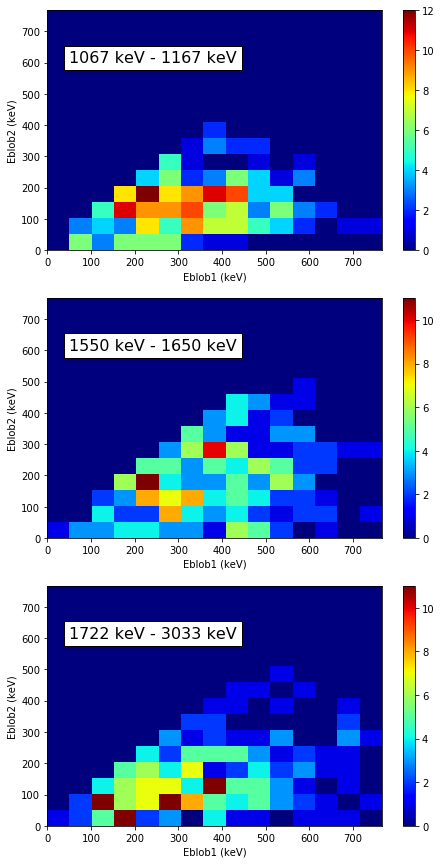

In [249]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 15

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(7.5);

# define intervals
eb1_low = 320000; eb1_high = 350000
eb2_low = 465000; eb2_high = 495000
eb3_low = 516600; eb3_high = 910000

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# cuts
cuts_1 = ((l_etrk > eb1_low) & (l_etrk < eb1_high))
cuts_2 = ((l_etrk > eb2_low) & (l_etrk < eb2_high))
cuts_3 = ((l_etrk > eb3_low) & (l_etrk < eb3_high))

print("Number of events I1 ({0} keV, {1} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(l_eblob1[cuts_1])))
print("Number of events I2 ({0} keV, {1} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(l_eblob1[cuts_2])))
print("Number of events I3 ({0} keV, {1} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(l_eblob1[cuts_3])))

# interval 1
ax1 = fig.add_subplot(311);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_1]*CAL_FACTOR, l_eblob2[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax1.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

# interval 2
ax2 = fig.add_subplot(312);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_2]*CAL_FACTOR, l_eblob2[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax2.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent2 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = ax2.imshow(hxy, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Eblob1 (keV)")
ax2.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp2)

# interval 3
ax3 = fig.add_subplot(313);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_3]*CAL_FACTOR, l_eblob2[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax3.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

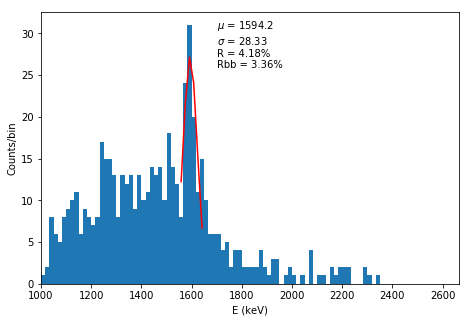

In [254]:
# track-energy spectrum
#CAL_FACTOR = 1600/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(l_etrk[l_eblob1 > 200/CAL_FACTOR]*CAL_FACTOR, 100, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 465e3*CAL_FACTOR, 495e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

In [ ]:
# Plot Eblob1 vs. Eblob2
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

Ecut_low_blobs = 0
Ecut_high_blobs = 301000

xcut_low = 15000
xcut_high = 285000

#cuts_blob = ((dist_cuts) & (l_dblobs > trklen_low))
#((l_etotcorr > Ecut_low) & (l_etotcorr < Ecut_high) & 
#             (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs) & 
#             (l_dblobs > trklen_low))
cuts_blob = (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs)
#print(l_hcindex[np.nonzero(cuts_blob & (l_eblob1 > 500))])
print("Number of events: {0}".format(len(l_eblob1[cuts_blob])))

# create the x-y projection
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_blob]*CAL_FACTOR, l_eblob2[cuts_blob]*CAL_FACTOR, normed=False, bins=(20, 20))
#hxy, xxy, yxy = np.histogram2d(l_eblob1, l_eblob2, normed=False, bins=(20, 20))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#extent2 = [0, 200000, 0, 200000]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob1 (keV)")
plt.ylabel("Eblob2 (keV)")
plt.xlim([xcut_low*CAL_FACTOR,xcut_high*CAL_FACTOR])
plt.ylim([xcut_low*CAL_FACTOR,xcut_high*CAL_FACTOR])
#plt.xlim([Ecut_low_blobs,max(l_eblob2[cuts_blob])])
#plt.ylim([Ecut_low_blobs,max(l_eblob1[cuts_blob])])
plt.colorbar()

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(e_spec[l_eblob1 < 20000],bins=30,label='Single-track')
plt.hist(e_spec[l_eblob1 > 20000],bins=40,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

In [ ]:
nevt = 30
hitc = hitc_evt[nevt]
print("Running Paolina for event {0} (event number {1}) with blob radius {2}".format(nevt,evtnum_hitc[nevt],blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (Q)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3}".format(a.pos[0],a.pos[1],a.pos[2],Eblob1))
print("Extreme1 at ({0},{1},{2}) with energy {3}".format(b.pos[0],b.pos[1],b.pos[2],Eblob2))

In [ ]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)

print(sum(mcarr_c))
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# true track
ax1 = fig.add_subplot(121, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(122, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
#ax3 = fig.add_subplot(133, projection='3d')
#sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
#xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
#yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
#zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
#ax3.set_xlabel("x (mm)")
#ax3.set_ylabel("y (mm)")
#ax3.set_zlabel("z (mm)")
#ax3.set_title("Paolina Track")
#lb_x = ax3.get_xticklabels()
#lb_y = ax3.get_yticklabels()
#lb_z = ax3.get_zticklabels()
#for lb in (lb_x + lb_y + lb_z):
#    lb.set_fontsize(8.)
#cbp1 = plt.colorbar(sc3d)
#cbp1.set_label('Energy (Q)')

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(trk_energies,bins=200)
ax1.set_title("Paolina track energies")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_xlim([0,10000])
#ax2.set_yscale("log")

nn = 0
for ee,te in zip(evtnum_hitc,trk_energies):
    if(400 < te < 20000):
        print("Event {0} (number {1})".format(nn,ee))
    nn += 1

## Histograms from the Corona step

In [ ]:
# total charge
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# charge histogram
#ax1 = fig.add_subplot(121);
#plt.hist(l_qsipm,bins=200)
#ax1.set_title("Charge in all SiPMs in PMaps")
#ax1.set_xlabel("Charge (Q)")
#ax1.set_ylabel("Counts/bin")
#ax1.set_yscale("log")

# charge vs. cluster energy
ax2 = fig.add_subplot(111);
plt.scatter(l_qsipm_ccenter,l_qsipm_qcluster,marker='.',s=0.5)
ax2.set_title("Central charge of cluster vs. total charge of cluster")
ax2.set_xlabel("Central charge (Q)")
ax2.set_ylabel("Cluster charge (Q)")
#ax1.set_yscale("log")

In [ ]:
# cluster charges
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
plt.hist(l_qsipm_cluster,bins=200)
ax1.set_title("Charge in all SiPMs in clusters")
ax1.set_xlabel("Charge (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
#hxy, xxy, yxy = np.histogram2d(l_etotcorr[dist_cuts], l_zavg[dist_cuts], normed=False, bins=(30, 30))
#extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
plt.hist(l_qsipm_ccenter,bins=200)
ax2.set_title("Central cluster charge")
ax2.set_xlabel("Charge (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

In [ ]:
# cluster charge vs. radial distance from local maxima
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
#plt.scatter(l_r_rlm,l_q_rlm,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rlm, l_r_rlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp1 = plt.colorbar(sp1)
ax1.set_title("SiPM charge vs. radius from initial local maximum")
ax1.set_xlabel("Radial distance (mm)")
ax1.set_ylabel("SiPM charge")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rnlm, l_r_rnlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp2 = plt.colorbar(sp2)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#plt.scatter(l_r_rnlm,l_q_rnlm,marker='.')
ax2.set_title("SiPM charge vs. radius from second local maximum")
ax2.set_xlabel("Radial distance (mm)")
ax2.set_ylabel("SiPM charge")

In [ ]:
# cluster charges
fig = plt.figure(4);
fig.set_figheight(15.0);
fig.set_figwidth(15.0);

# charge histograms for max clusters
for n in range(nccenters):
    splt_str = "32{0}".format(n+1)
    ax1 = fig.add_subplot(splt_str);
    plt.hist(l_qsipm_iccenter[n],bins=200)
    ax1.set_title("SiPM central charge for cluster {0}".format(n))
    ax1.set_xlabel("Charge (Q)")
    ax1.set_ylabel("Counts/bin")
    ax1.set_yscale("log")
    print("{0} entries for cluster {1}".format(len(l_qsipm_iccenter[n]),n))

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

# Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])

In [ ]:
# run Paolina for many events
trk_energies = [];
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
#for nevt in range(1000):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[nevt]])
    if(len(hitc_evt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[nevt]])/np.exp(-evt_Z/tlife)
    
    # Make energy and radial cuts.
    if(not (evt_Ecorrtau_xy_slice > ECCUT_LOW and evt_Ecorrtau_xy_slice < ECCUT_HIGH) or evt_R >= 150.):
        continue
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    if(len(trks[itmax])/len(voxels) < 0.95):
        continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
l_eblob1.append(250000)
l_eblob2.append(250000)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)